<a href="https://colab.research.google.com/github/yUHenGZhOng/School-Project/blob/main/%E2%80%9CFacialExpAnalysis_Facenet_test_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy>=1.24.1
!pip install py-feat

In [ ]:
!pip install --upgrade py-feat

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os

def save_frames(video_path, step_sec, dir_path, basename, ext='jpg'):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return

    os.makedirs(dir_path, exist_ok=True)
    base_path = os.path.join(dir_path, basename)

    digit = len(str(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))))

    fps = cap.get(cv2.CAP_PROP_FPS)
    fps_inv = 1 / fps

    sec = step_sec
    while True:
        n = round(fps * sec)
        cap.set(cv2.CAP_PROP_POS_FRAMES, n)
        ret, frame = cap.read()
        if ret:
            cv2.imwrite(f'{base_path}_{str(n).zfill(digit)}_{(n * fps_inv):.2f}.{ext}', frame)
        else:
            return
        sec += step_sec

In [ ]:
INTERVAL_SEC = 60 #提取间隔秒数

save_frames('/content/drive/MyDrive/FacialExpAnalysis/sample_movie.mp4',
            INTERVAL_SEC, '/content/drive/MyDrive/FacialExpAnalysis/frames/', 'frame', 'png')

Initialize detector

In [ ]:
from feat import Detector
detector = Detector(
    face_model="retinaface",
    landmark_model="mobilefacenet",
    au_model='xgb',
    emotion_model="resmasknet",
    facepose_model="img2pose",
    identity_model="facenet"
)
detector
# 读取数据
import glob

files = glob.glob("/content/drive/MyDrive/FacialExpAnalysis/frames/*")
print(files)

100%|██████████| 111898327/111898327 [00:00<00:00, 254031339.09it/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


feat.detector.Detector(face_model=retinaface, landmark_model=mobilefacenet, au_model=xgb, emotion_model=resmasknet, facepose_model=img2pose, identity_model=facenet)

主处理

In [ ]:
import pandas as pd
import numpy as np

# 处理所有图像
all_predictions = []
for frame, image in enumerate(files):
    prediction = detector.detect_image(image)
    prediction['frame'] = frame
    all_predictions.append(prediction)

# 合并所有预测结果
all_predictions = pd.concat(all_predictions, ignore_index=True)

# 计算身份
all_predictions = all_predictions.compute_identities(threshold=0.7, inplace=False)#阈值调整

# 添加face_id列
all_predictions['face_id'] = all_predictions['frame'].astype(str) + '_' + all_predictions['FaceRectX'].astype(str) + '_' + all_predictions['FaceRectY'].astype(str)

# 打印身份信息
print(all_predictions['Identity'].value_counts())

# 可视化结果
import os

output_dir = '/content/drive/MyDrive/FacialExpAnalysis/output/'
os.makedirs(output_dir, exist_ok=True)

for frame, group in all_predictions.groupby('frame'):
    img = cv2.imread(files[frame])
    for _, face in group.iterrows():
        x, y = int(face['FaceRectX']), int(face['FaceRectY'])
        w, h = int(face['FaceRectWidth']), int(face['FaceRectHeight'])
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img, f"ID: {face['Identity']}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
    output_path = os.path.join(output_dir, f'frame_{frame}.jpg')
    cv2.imwrite(output_path, img)
    print(f"Saved image to {output_path}")

print(f"Total images saved: {len(os.listdir(output_dir))}")

100%|██████████| 1/1 [00:05<00:00,  5.50s/it]


Identity
Person_0    10
Person_1     9
Person_3     9
Person_4     8
Person_2     1
Person_5     1
Person_6     1
Name: count, dtype: int64
Saved image to /content/drive/MyDrive/FacialExpAnalysis/output/frame_0.jpg
Saved image to /content/drive/MyDrive/FacialExpAnalysis/output/frame_1.jpg
Saved image to /content/drive/MyDrive/FacialExpAnalysis/output/frame_2.jpg
Saved image to /content/drive/MyDrive/FacialExpAnalysis/output/frame_3.jpg
Saved image to /content/drive/MyDrive/FacialExpAnalysis/output/frame_4.jpg
Saved image to /content/drive/MyDrive/FacialExpAnalysis/output/frame_5.jpg
Saved image to /content/drive/MyDrive/FacialExpAnalysis/output/frame_6.jpg
Saved image to /content/drive/MyDrive/FacialExpAnalysis/output/frame_7.jpg
Saved image to /content/drive/MyDrive/FacialExpAnalysis/output/frame_8.jpg
Saved image to /content/drive/MyDrive/FacialExpAnalysis/output/frame_9.jpg
Total images saved: 11


In [ ]:
# from collections import Counter

# def smooth_identities(df, window_size=3):
#     def mode_function(x):
#         counts = Counter(x)
#         if counts:
#             return max(counts, key=counts.get)
#         return x.iloc[-1] if len(x) > 0 else None

#     df = df.sort_values(['frame'])

#     # 创建一个滑动窗口
#     windows = [df['Identity'].iloc[max(0, i-window_size//2):min(len(df), i+window_size//2+1)]
#                for i in range(len(df))]

#     # 对每个窗口应用mode_function
#     df['smooth_identity'] = [mode_function(window) for window in windows]

#     return df

# # 使用修改后的函数
# all_predictions = smooth_identities(all_predictions)
# print(all_predictions['smooth_identity'].value_counts())

smooth_identity
Person_3    11
Person_1    10
Person_4     8
Person_0     7
Person_2     1
Person_5     1
Person_6     1
Name: count, dtype: int64


In [ ]:
all_predictions


,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,FaceScore,x_0,x_1,x_2,x_3,x_4,...,Identity_507,Identity_508,Identity_509,Identity_510,Identity_511,Identity_512,input,frame,face_id,smooth_identity
0,278.462517,544.859051,111.316034,155.558931,0.999339,278.674730,278.074472,279.888388,283.719940,289.622723,...,-0.002919,0.023474,-0.016600,-0.056269,-0.052870,0.005739,/content/drive/MyDrive/FacialExpAnalysis/frame...,0,0_278.46251695421006_544.8590512818928,Person_0
1,799.959917,401.590692,152.546302,219.774124,0.997433,797.742305,797.066434,798.668861,802.943347,810.122252,...,-0.043172,0.031999,-0.027189,-0.083009,0.003488,-0.022531,/content/drive/MyDrive/FacialExpAnalysis/frame...,0,0_799.9599168565538_401.5906920614122,Person_0
2,816.539277,143.013197,84.453644,113.511307,0.984846,826.359181,826.130714,827.098920,830.189492,834.139834,...,-0.021251,-0.004506,-0.025651,-0.096284,0.045904,0.009231,/content/drive/MyDrive/FacialExpAnalysis/frame...,0,0_816.5392768012152_143.01319653474832,Person_1
3,827.086647,430.336315,138.627170,191.205603,0.999671,825.613005,825.412640,826.996717,830.396463,835.448839,...,-0.036676,0.045582,0.012750,-0.088200,0.011863,0.002355,/content/drive/MyDrive/FacialExpAnalysis/frame...,1,1_827.0866468641493_430.3363152998912,Person_2
4,290.278952,54.856062,103.472127,134.494694,0.999402,295.375183,293.313899,292.675432,293.187785,295.189557,...,-0.051201,0.012808,0.032799,-0.012736,0.010285,0.050014,/content/drive/MyDrive/FacialExpAnalysis/frame...,1,1_290.27895202636716_54.85606181470654,Person_1
5,286.591230,550.424496,102.795632,144.121642,0.998946,283.203291,282.939587,285.176913,289.669923,296.422277,...,0.010883,0.015006,-0.025931,-0.055431,-0.032918,0.012730,/content/drive/MyDrive/FacialExpAnalysis/frame...,1,1_286.59122992621525_550.4244956487343,Person_3
6,894.131104,124.431891,85.769883,115.304721,0.997081,899.839505,898.950995,899.374209,901.130557,904.332061,...,-0.054107,0.075757,-0.006806,-0.071987,-0.048100,-0.012634,/content/drive/MyDrive/FacialExpAnalysis/frame...,1,1_894.131103515625_124.43189113954955,Person_0
9,266.967159,42.615667,147.780082,188.366545,0.997935,271.809490,273.367002,277.188272,283.071534,292.305006,...,-0.019612,-0.076845,0.031981,-0.020411,0.076569,0.058350,/content/drive/MyDrive/FacialExpAnalysis/frame...,2,2_266.96715867784286_42.61566693269754,Person_4
10,887.053163,125.683550,83.557222,112.281169,0.997411,894.978208,894.833952,895.796645,897.893878,901.209024,...,-0.020612,0.093936,-0.006467,-0.043086,-0.052550,-0.033302,/content/drive/MyDrive/FacialExpAnalysis/frame...,2,2_887.0531629774306_125.68355029142356,Person_3
7,292.033624,547.238704,101.125931,140.404613,0.999196,291.951869,292.116950,294.463320,299.012506,306.060952,...,-0.008471,0.019620,-0.048551,-0.055555,-0.035018,-0.000635,/content/drive/MyDrive/FacialExpAnalysis/frame...,2,2_292.03362358940973_547.2387038605123,Person_4


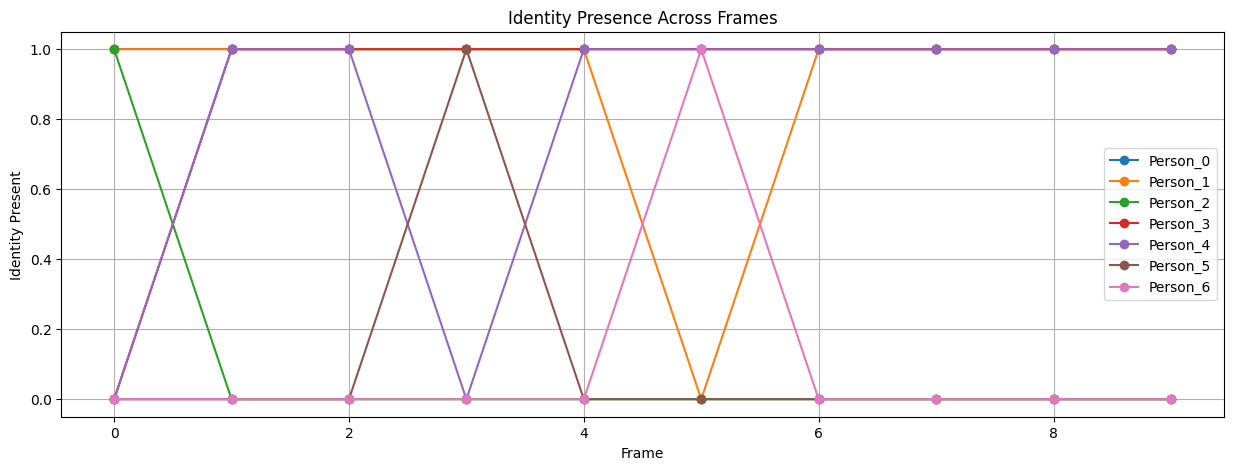

In [ ]:
import matplotlib.pyplot as plt

identity_by_frame = all_predictions.pivot(index='frame', columns='Identity', values='Identity')
identity_by_frame = identity_by_frame.notna()

plt.figure(figsize=(15, 5))
for col in identity_by_frame.columns:
    plt.plot(identity_by_frame.index, identity_by_frame[col], label=col, marker='o')
plt.xlabel('Frame')
plt.ylabel('Identity Present')
plt.title('Identity Presence Across Frames')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'identity_presence.png'))


In [ ]:
print(all_predictions.groupby('frame')['Identity'].count())

frame
0    3
1    4
2    4
3    4
4    4
5    4
6    4
7    4
8    4
9    4
Name: Identity, dtype: int64


-------------------------------------------------------------------------------

100%|██████████| 1/1 [00:10<00:00, 10.85s/it]


,anger,disgust,fear,happiness,sadness,surprise,neutral,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,x,y,frame,face_id
0,0.001938,0.000127,0.000317,0.003750,0.047360,0.005425,0.941083,278.462544,544.859051,111.316007,155.558931,334.120547,622.638517,0,0_278.46254374186196_544.8590512818928
1,0.000284,0.000795,0.000287,0.014668,0.001700,0.001236,0.981030,799.959970,401.590692,152.546356,219.774054,876.233148,511.477719,0,0_799.9599704318576_401.5906920614122
2,0.126358,0.027632,0.030244,0.702119,0.016847,0.048175,0.048624,816.539277,143.013197,84.453644,113.511307,858.766099,199.768850,0,0_816.5392768012152_143.01319653474832
3,0.000891,0.000158,0.000074,0.001022,0.000895,0.000075,0.996884,827.086647,430.336350,138.627170,191.205568,896.400232,525.939134,1,1_827.0866468641493_430.3363500667524
4,0.001612,0.000033,0.000130,0.008462,0.070592,0.001341,0.917830,290.278952,54.856062,103.472127,134.494694,342.015016,122.103409,1,1_290.27895202636716_54.85606181470654
5,0.000644,0.000150,0.000657,0.005069,0.099686,0.004208,0.889585,286.591230,550.424496,102.795632,144.121642,337.989046,622.485317,1,1_286.59122992621525_550.4244956487343
6,0.109567,0.000321,0.003731,0.000808,0.031572,0.021508,0.832492,894.131104,124.431891,85.769883,115.304721,937.016045,182.084252,1,1_894.131103515625_124.43189113954955
7,0.000993,0.004354,0.030042,0.807414,0.126261,0.015477,0.015459,292.033624,547.238704,101.125931,140.404613,342.596589,617.441010,2,2_292.03362358940973_547.2387038605123
8,0.002064,0.007246,0.003357,0.000610,0.001327,0.000336,0.985060,841.478956,413.278129,144.806171,196.393131,913.882041,511.474694,2,2_841.4789557562934_413.2781287084652
9,0.001207,0.001141,0.000958,0.514166,0.232473,0.000841,0.249214,266.967159,42.615654,147.780082,188.366576,340.857200,136.798942,2,2_266.96715867784286_42.61565389512461


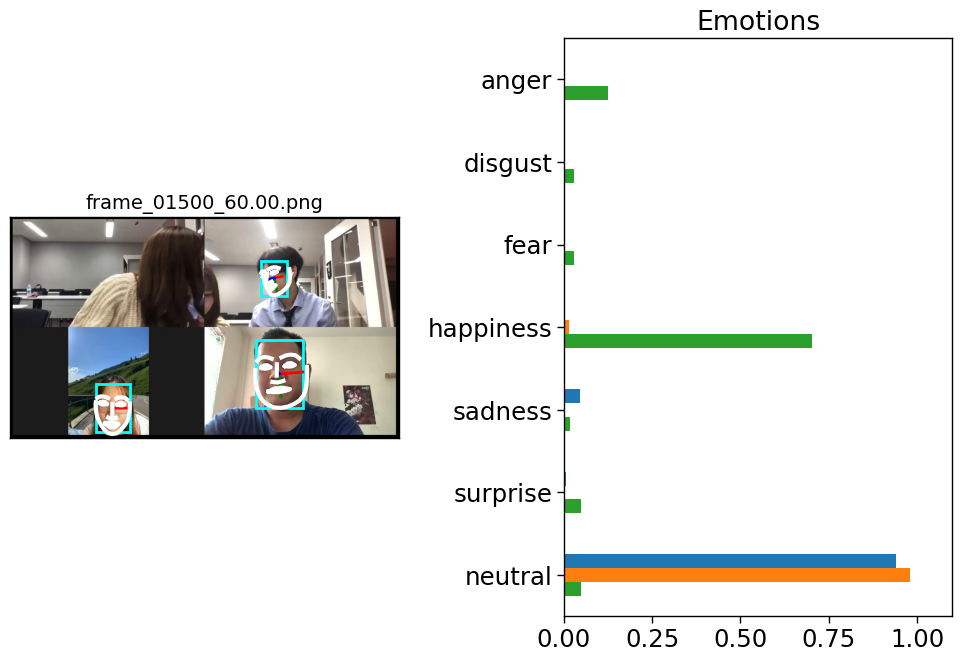

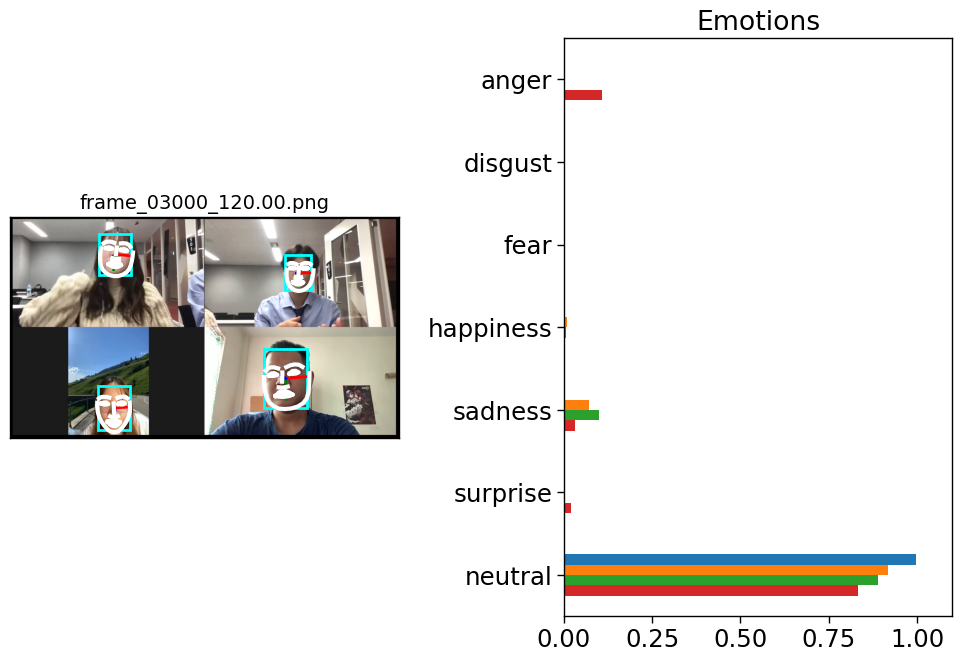

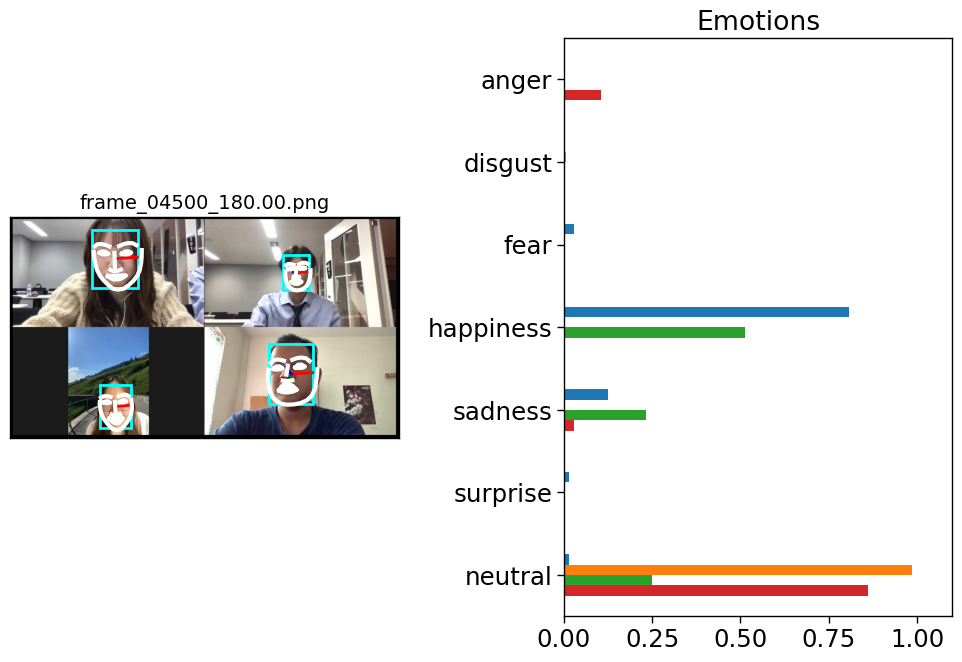

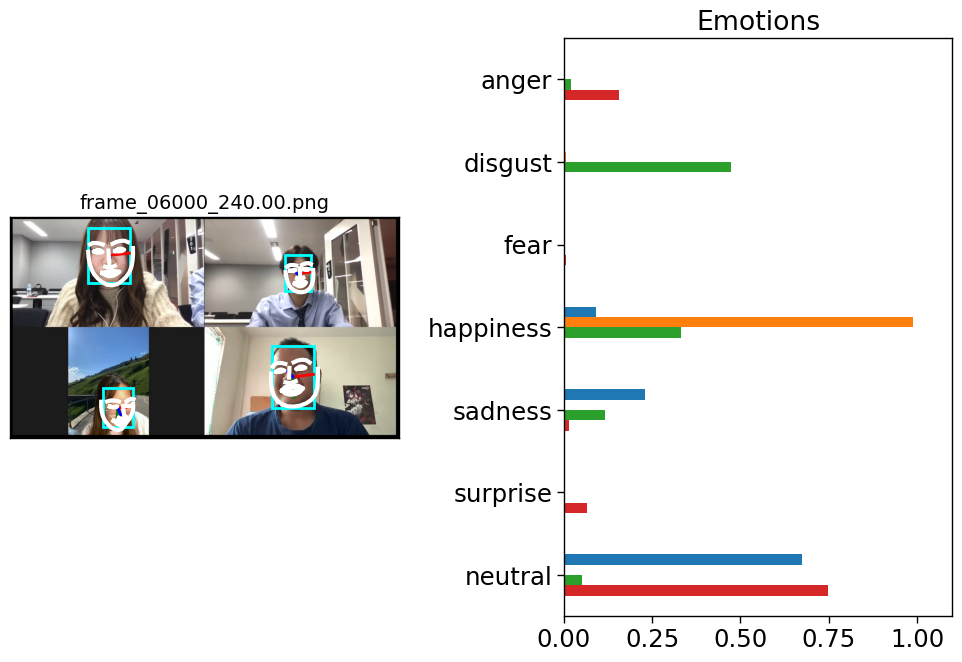

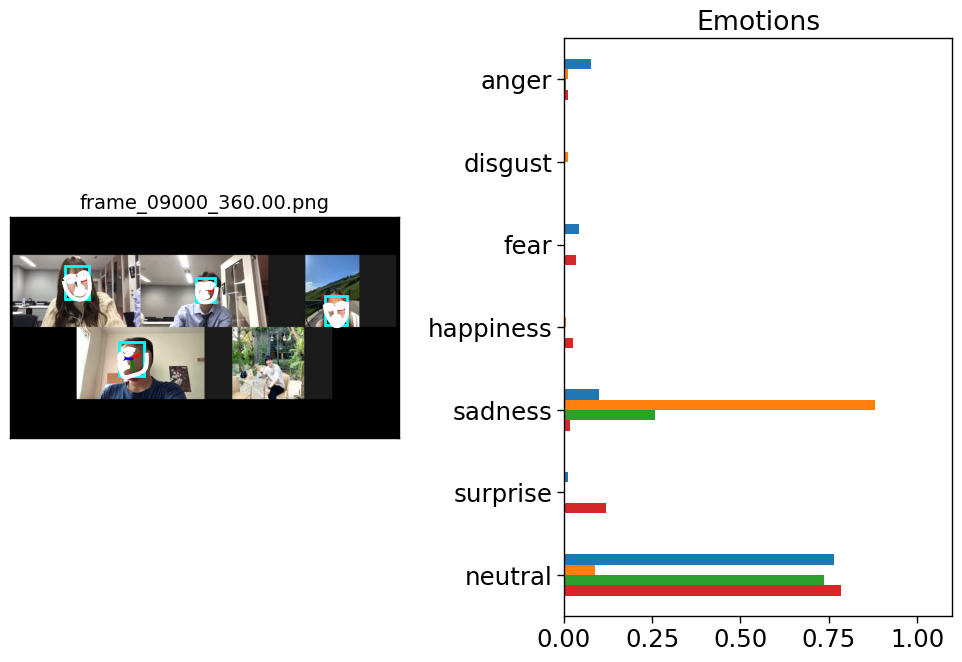

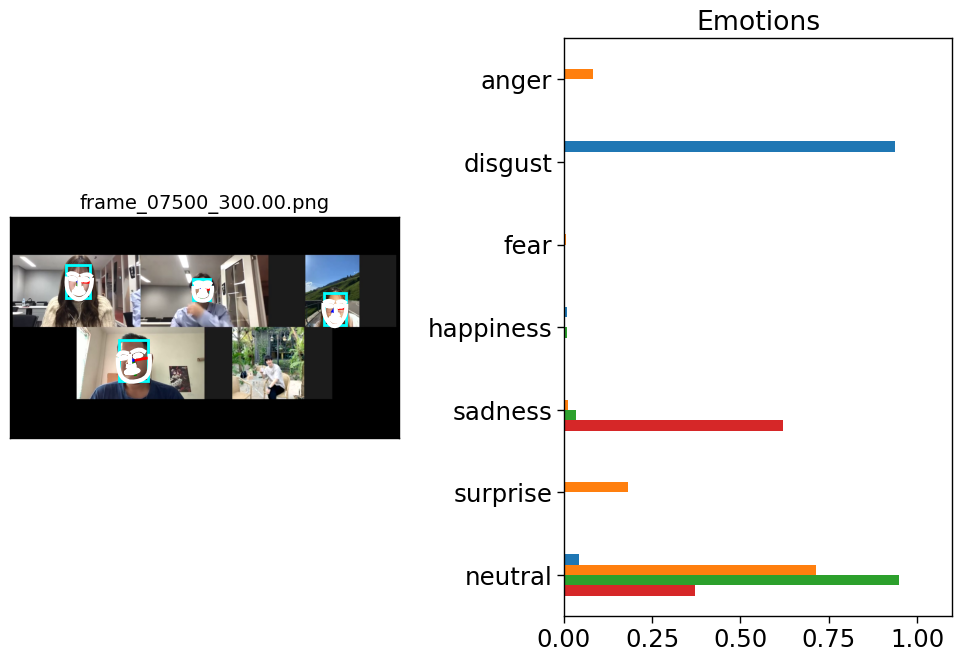

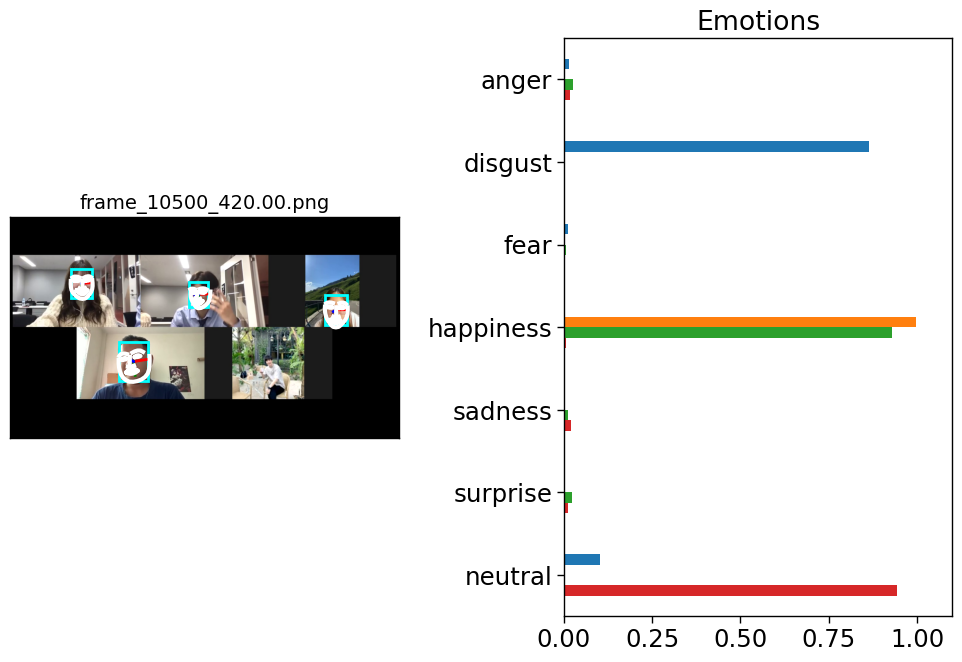

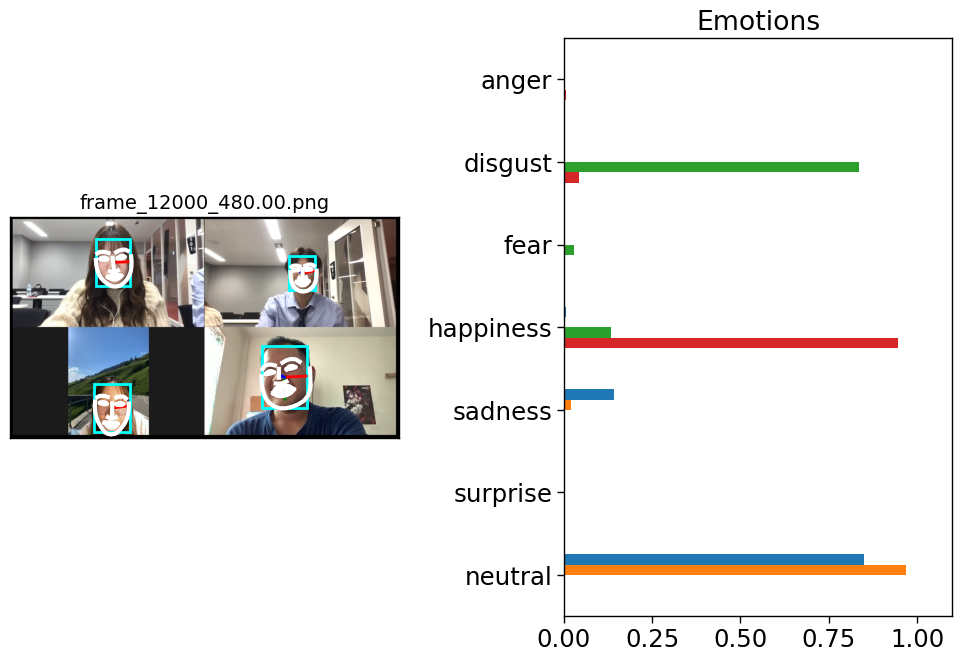

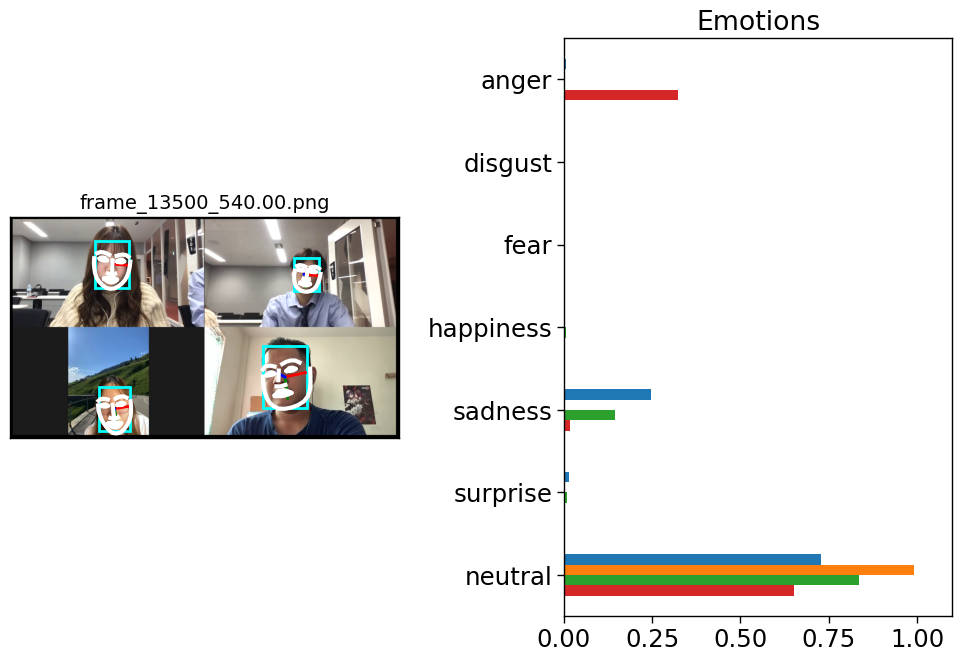

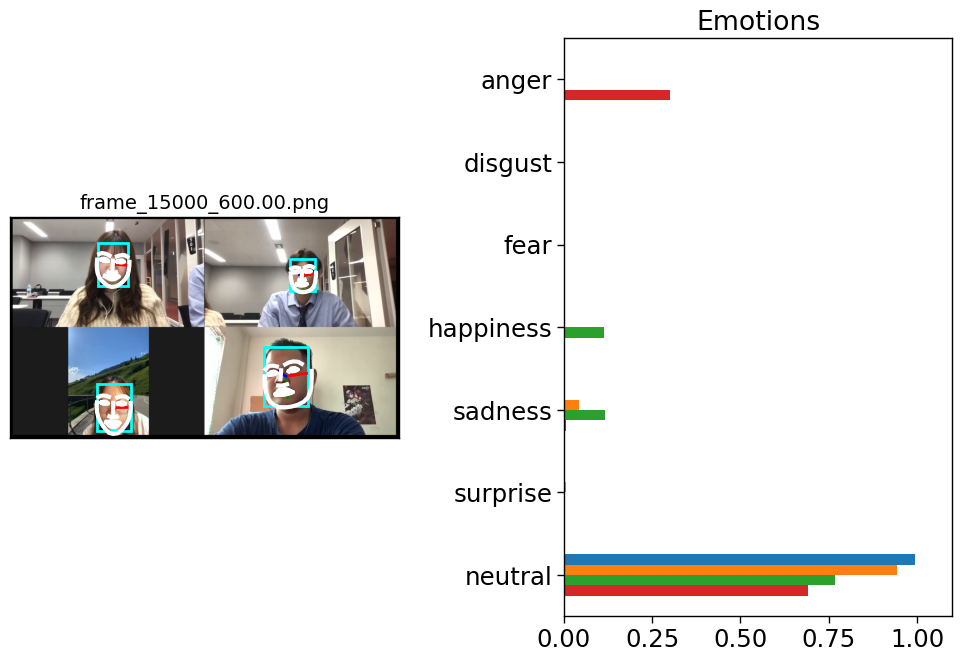

In [ ]:
import pandas as pd

frame = 0
dfs = []
for image in files:
    face_prediction = detector.detect_image(image)
    face_prediction.plot_detections(au_barplot=False, poses=True)

    df = face_prediction[['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral',
                          'FaceRectX', 'FaceRectY', 'FaceRectWidth', 'FaceRectHeight']].copy()
    df['x'] = face_prediction['FaceRectX'] + face_prediction['FaceRectWidth'] / 2
    df['y'] = face_prediction['FaceRectY'] + face_prediction['FaceRectHeight'] / 2
    df['frame'] = frame
    df['face_id'] = str(frame) + '_' + df['FaceRectX'].astype(str) + '_' + df['FaceRectY'].astype(str)
    dfs.append(df)

    frame += 1

all_faces = pd.concat(dfs).reset_index(drop=True)


all_faces

In [ ]:
# 假设 all_faces 已经包含了 face_id
all_predictions = pd.concat([detector.detect_image(file) for file in files], ignore_index=True)
all_predictions = all_predictions.compute_identities(threshold=0.9, inplace=False)
all_predictions['face_id'] = all_predictions['frame'].astype(str) + '_' + all_predictions['FaceRectX'].astype(str) + '_' + all_predictions['FaceRectY'].astype(str)
all_predictions


100%|██████████| 1/1 [00:11<00:00, 12.00s/it]


,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,FaceScore,x_0,x_1,x_2,x_3,x_4,...,Identity_506,Identity_507,Identity_508,Identity_509,Identity_510,Identity_511,Identity_512,input,frame,face_id
0,278.462544,544.859051,111.316007,155.558931,0.999339,278.674730,278.074475,279.888391,283.719946,289.622729,...,0.089310,-0.002919,0.023474,-0.016600,-0.056269,-0.052870,0.005739,/content/drive/MyDrive/FacialExpAnalysis/frame...,0,0_278.46254374186196_544.8590512818928
1,799.959970,401.590692,152.546356,219.774054,0.997433,797.742288,797.066422,798.668848,802.943332,810.122228,...,-0.021636,-0.043172,0.031999,-0.027189,-0.083009,0.003488,-0.022531,/content/drive/MyDrive/FacialExpAnalysis/frame...,0,0_799.9599704318576_401.5906920614122
2,816.539277,143.013197,84.453644,113.511307,0.984846,826.359181,826.130718,827.098924,830.189492,834.139842,...,0.055761,-0.021251,-0.004506,-0.025651,-0.096284,0.045904,0.009231,/content/drive/MyDrive/FacialExpAnalysis/frame...,0,0_816.5392768012152_143.01319653474832
3,827.086647,430.336350,138.627170,191.205568,0.999671,825.612997,825.412635,826.996712,830.396461,835.448839,...,0.004162,-0.036676,0.045582,0.012750,-0.088200,0.011864,0.002355,/content/drive/MyDrive/FacialExpAnalysis/frame...,0,0_827.0866468641493_430.3363500667524
4,290.278952,54.856062,103.472127,134.494694,0.999402,295.375181,293.313894,292.675427,293.187778,295.189552,...,0.024643,-0.051201,0.012808,0.032799,-0.012736,0.010285,0.050014,/content/drive/MyDrive/FacialExpAnalysis/frame...,0,0_290.27895202636716_54.85606181470654
5,286.591230,550.424496,102.795632,144.121642,0.998946,283.203288,282.939585,285.176908,289.669920,296.422272,...,0.078070,0.010883,0.015006,-0.025931,-0.055431,-0.032918,0.012730,/content/drive/MyDrive/FacialExpAnalysis/frame...,0,0_286.59122992621525_550.4244956487343
6,894.131104,124.431891,85.769883,115.304721,0.997081,899.839505,898.950993,899.374209,901.130557,904.332061,...,0.087474,-0.054107,0.075757,-0.006806,-0.071987,-0.048100,-0.012634,/content/drive/MyDrive/FacialExpAnalysis/frame...,0,0_894.131103515625_124.43189113954955
7,292.033624,547.238704,101.125931,140.404613,0.999196,291.951869,292.116950,294.463322,299.012509,306.060952,...,0.073647,-0.008471,0.019619,-0.048551,-0.055555,-0.035018,-0.000635,/content/drive/MyDrive/FacialExpAnalysis/frame...,0,0_292.03362358940973_547.2387038605123
8,841.478956,413.278129,144.806171,196.393131,0.999107,840.893378,838.901365,839.020566,841.512635,845.954767,...,-0.005434,-0.080870,0.047010,0.031669,-0.095670,0.026785,0.011593,/content/drive/MyDrive/FacialExpAnalysis/frame...,0,0_841.4789557562934_413.2781287084652
9,266.967159,42.615654,147.780082,188.366576,0.997935,271.809494,273.367006,277.188283,283.071540,292.305023,...,0.055186,-0.019612,-0.076845,0.031981,-0.020411,0.076569,0.058350,/content/drive/MyDrive/FacialExpAnalysis/frame...,0,0_266.96715867784286_42.61565389512461


In [ ]:
all_predictions['Identity']

0      Person_0
1      Person_1
2      Person_2
3      Person_3
4      Person_4
5      Person_0
6      Person_5
7      Person_0
8      Person_6
9      Person_7
10     Person_8
11     Person_9
12    Person_10
13    Person_11
14    Person_12
15    Person_13
16     Person_0
17     Person_9
18    Person_14
19     Person_3
20    Person_15
21     Person_0
22     Person_9
23     Person_3
24    Person_16
25    Person_17
26     Person_0
27     Person_9
28     Person_0
29    Person_10
30    Person_18
31    Person_19
32     Person_3
33     Person_0
34    Person_20
35     Person_3
36     Person_0
37     Person_9
38     Person_8
Name: Identity, dtype: object

In [ ]:
# 将 Identity 信息合并到 all_faces
all_faces = pd.merge(all_faces, all_predictions[['face_id', 'Identity']], on='face_id', how='left')
all_faces

In [ ]:
all_faces['Identity']

0     Person_0
1     Person_1
2     Person_2
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16         NaN
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
30         NaN
31         NaN
32         NaN
33         NaN
34         NaN
35         NaN
36         NaN
37         NaN
38         NaN
Name: Identity, dtype: object

顔の中心位置でクラスタリングする

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
clustering_sc = sc.fit_transform(all_faces[['x','y']]) # (x, y)の位置でクラスタリングする
kmeans = KMeans(n_clusters=max_faces, random_state=0)
clusters = kmeans.fit(clustering_sc)

all_faces["cluster_no"] = clusters.labels_
all_faces

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,index,anger,disgust,fear,happiness,sadness,surprise,neutral,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,x,y,frame,cluster_no
0,0,0.001399,0.000342,0.002873,0.048940,0.013673,0.024014,0.908758,119.338392,136.919990,123.314928,165.191846,180.995856,219.515913,0,2
1,1,0.002345,0.000726,0.001498,0.922050,0.004390,0.016702,0.052290,588.784180,143.116708,100.199273,135.172477,638.883816,210.702946,0,4
2,2,0.009482,0.000691,0.000120,0.189186,0.007091,0.012180,0.781250,371.999403,423.062347,73.330838,92.609871,408.664822,469.367283,0,0
3,3,0.030013,0.000852,0.007278,0.002890,0.008120,0.044541,0.906307,1012.173503,188.644867,76.539388,105.437199,1050.443197,241.363466,0,1
4,4,0.063640,0.002863,0.004334,0.609548,0.017740,0.177065,0.124810,836.025716,477.585640,161.123589,220.233582,916.587511,587.702431,0,3
5,0,0.026447,0.010873,0.005969,0.262172,0.020420,0.061960,0.612160,117.253933,144.155354,113.178277,154.643417,173.843072,221.477062,1,2
6,1,0.000274,0.000030,0.000032,0.413481,0.074263,0.000307,0.511613,564.733941,149.844109,100.936469,134.345764,615.202176,217.016991,1,4
7,2,0.002672,0.000363,0.001104,0.287604,0.003241,0.017695,0.687320,1006.531901,181.595627,86.153429,118.165787,1049.608615,240.678520,1,1
8,3,0.000338,0.009902,0.000073,0.984503,0.000659,0.000816,0.003710,381.357042,423.901325,72.756836,93.147411,417.735460,470.475031,1,0
9,4,0.059548,0.006879,0.000489,0.796407,0.010598,0.030190,0.095889,824.817220,470.904991,146.802897,178.382195,898.218669,560.096088,1,3


（クラスタリングされた）顔番号で分類して表情推移グラフを描く関数を定義

In [ ]:
from matplotlib import colormaps as cm

def show_graph(face_no):
  cmap = cm.get_cmap('Set1')
  df = all_faces[all_faces['cluster_no'] == face_no]
  df = df[['frame','anger','disgust','fear','happiness','sadness','surprise','neutral']]
  df.plot.bar(x='frame', stacked=True, cmap=cmap).legend(bbox_to_anchor=(1.0, 1.0))

各クラスタごとに表情の推移を示す

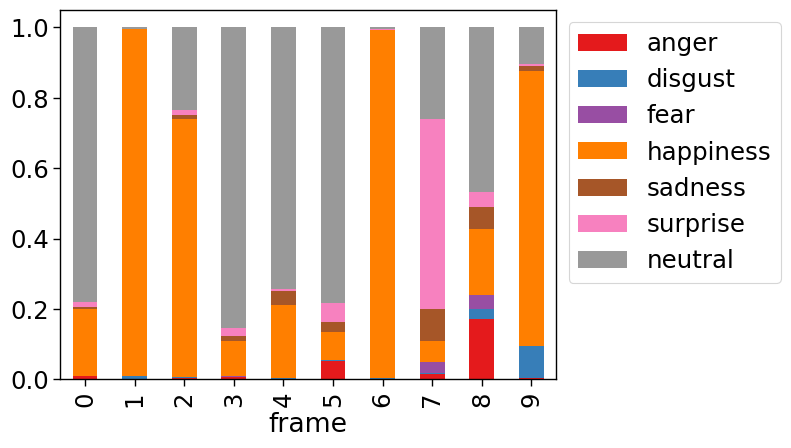

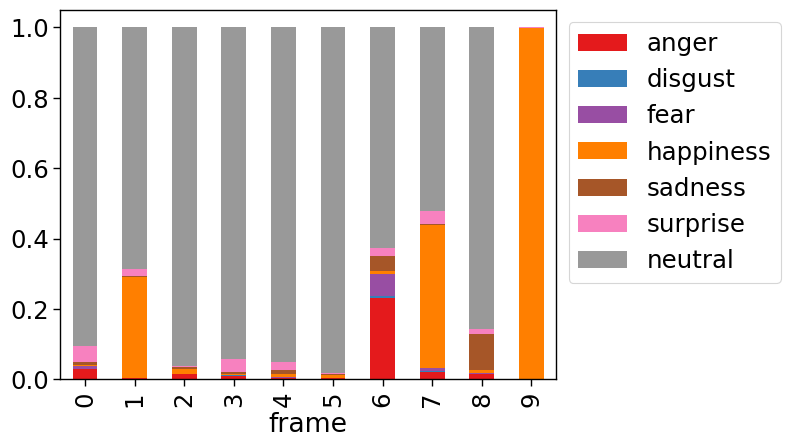

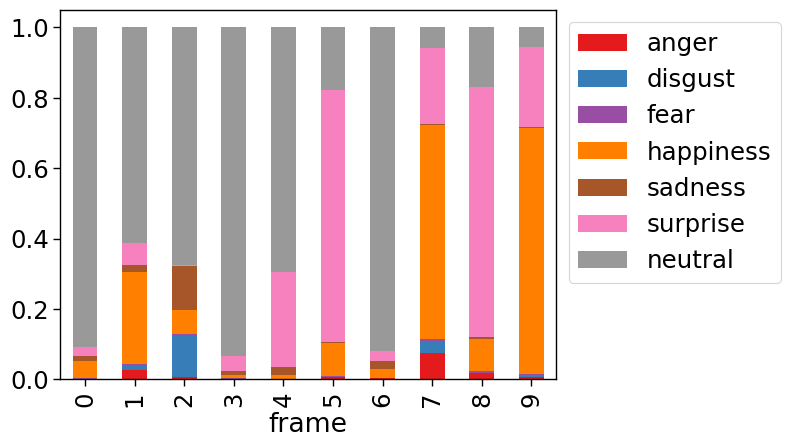

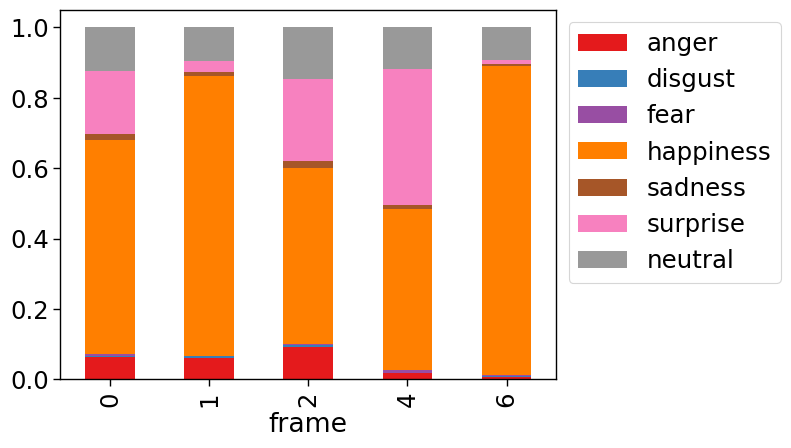

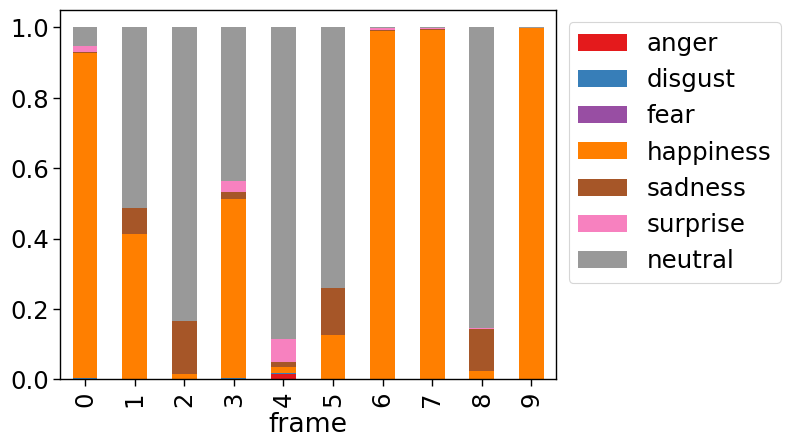

In [ ]:
for n in range(max_faces): show_graph(n)

レコードを指定して切り出し位置を抽出する関数を定義

In [ ]:
def face_rect(face):
    index = int(face['index'])
    frame = int(face['frame'])
    return dfs[frame][index:index+1][['FaceRectX','FaceRectY','FaceRectWidth','FaceRectHeight']].apply(int)

画像の一部を切り出す関数を定義

In [ ]:
from PIL import Image

def crop_image(frame_file, rectangle, dir_path, filename):
    os.makedirs(dir_path, exist_ok=True)
    file_path = os.path.join(dir_path, filename)

    im = Image.open(frame_file)
    rect = rectangle.to_dict()
    ulx = rect['FaceRectX']; uly = rect['FaceRectY']
    lrx = rect['FaceRectX'] + rect['FaceRectWidth']; lry = rect['FaceRectY'] + rect['FaceRectHeight']
    im_crop = im.crop((ulx, uly, lrx, lry))
    im_crop.save(file_path)

各話者ごとに切り出して保存

In [ ]:
for face_tuple in all_faces.iterrows():
  face = face_tuple[1]
  frame_no = int(face['frame'])
  cluster_no = int(face['cluster_no'])
  frame_file = files[frame_no]
  rectangle = face_rect(face)
  dir_path = f'/content/drive/MyDrive/FacialExpAnalysis/faces/{cluster_no}/'
  filename = f'image{frame_no}.png'
  crop_image(frame_file, rectangle, dir_path, filename)

<ipython-input-12-c574a32c85e0>:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return dfs[frame][index:index+1][['FaceRectX','FaceRectY','FaceRectWidth','FaceRectHeight']].apply(int)
<ipython-input-12-c574a32c85e0>:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return dfs[frame][index:index+1][['FaceRectX','FaceRectY','FaceRectWidth','FaceRectHeight']].apply(int)
<ipython-input-12-c574a32c85e0>:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return dfs[frame][index:index+1][['FaceRectX','FaceRectY','FaceRectWidth','FaceRectHeight']].apply(int)
<ipython-input-12-c574a32c85e0>:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.ilo

クラスタリング結果の検証

<Axes: xlabel='x', ylabel='y'>

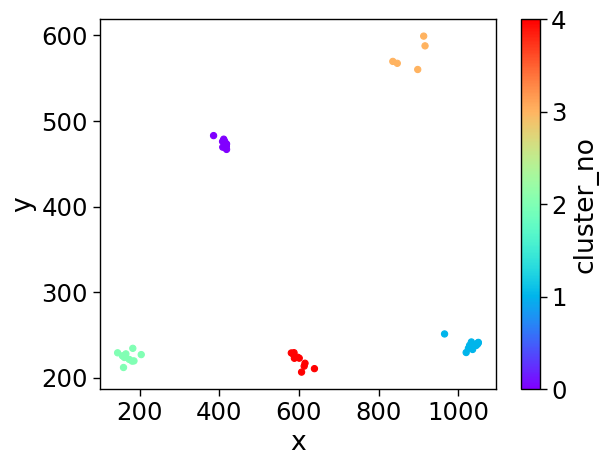

In [ ]:
all_faces[['x','y','cluster_no']].plot.scatter(x='x', y='y', c='cluster_no', cmap='rainbow')